# EMOTIC-E MODEL

# Installing required packages

In [ ]:
%tensorflow_version 2.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot
!pip install keras_applications

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


# Importing the required Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers
from tensorflow.python.lib.io import file_io
%matplotlib inline
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.layer_utils import get_source_inputs
#replace keras.engine.topology in models.py by keras.utils.layer_utils
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize pydot

# Defining the Constants

In [ ]:
EPOCHS = 50
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

IMG_SIZE = 197

# Loading the Dataset

In [ ]:
from google.colab import files
uploades=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
!kaggle datasets download -d msambare/fer2013

 96% 58.0M/60.3M [00:03<00:00, 23.3MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.2MB/s]


In [ ]:
!unzip fer2013.zip

# Pre-processing the Model

In [ ]:
classes=['angry','disgust','fear','happy','neutral','sad','surprise']
num_classes=len(classes)

In [ ]:
train_dir='train'
test_dir='test'

train_dg=ImageDataGenerator(rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
val_dg=ImageDataGenerator(rescale=1./255,
                          validation_split=0.5)
test_dg=ImageDataGenerator(rescale=1./255,
                          validation_split=0.5)
train_gen=train_dg.flow_from_directory(train_dir,
                                       target_size=(IMG_SIZE,IMG_SIZE),
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=BATCH_SIZE,)

val_gen=val_dg.flow_from_directory(test_dir,
                                       target_size=(IMG_SIZE,IMG_SIZE),
                                       class_mode='categorical',
                                       shuffle=True,
                                       color_mode='rgb',
                                       batch_size=BATCH_SIZE,
                                       subset='training')
test_gen=test_dg.flow_from_directory(test_dir,
                                     target_size=(IMG_SIZE,IMG_SIZE),
                                     class_mode='categorical',
                                     shuffle=True,
                                     color_mode='rgb',
                                     batch_size=BATCH_SIZE,
                                     subset='validation')

Found 28709 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.


# Compiling and Training the Model

In [ ]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
# l=0
# for layer in vgg_notop.layers:
#     print(layer,"["+str(l)+"]")
#     l=l+1

batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
# print('vgg layer 2 is trainable: ' + str(vgg_notop.layers[2].trainable))
# print('vgg layer 3 is trainable: ' + str(vgg_notop.layers[3].trainable))

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(learning_rate=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
early_stopping=keras.callbacks.EarlyStopping(patience=10)
model_checkpoint=keras.callbacks.ModelCheckpoint('my_checkpoint.h5',save_best_only=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)

In [ ]:
history = model.fit_generator(
    generator = train_gen,
    validation_data=val_gen,
    steps_per_epoch=28709// BATCH_SIZE,
    validation_steps=3509 // BATCH_SIZE,
    shuffle=True,
    epochs=50,
    callbacks=[rlrop,early_stopping,model_checkpoint]
)

<ipython-input-47-48d5537a2426>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
224/224 [==============================] - 342s 1s/step - loss: 1.8249 - accuracy: 0.3517 - val_loss: 1.8713 - val_accuracy: 0.1898 - lr: 0.0100
Epoch 2/50
224/224 [==============================] - 328s 1s/step - loss: 1.3618 - accuracy: 0.4868 - val_loss: 1.9808 - val_accuracy: 0.1765 - lr: 0.0100
Epoch 3/50
224/224 [==============================] - 324s 1s/step - loss: 1.2639 - accuracy: 0.5230 - val_loss: 1.4820 - val_accuracy: 0.4413 - lr: 0.0100
Epoch 4/50
224/224 [==============================] - 332s 1s/step - loss: 1.2089 - accuracy: 0.5440 - val_loss: 1.1231 - val_accuracy: 0.5735 - lr: 0.0100
Epoch 5/50
224/224 [==============================] - 327s 1s/step - loss: 1.1609 - accuracy: 0.5681 - val_loss: 1.0499 - val_accuracy: 0.6108 - lr: 0.0100
Epoch 6/50
224/224 [==============================] - 328s 1s/step - loss: 1.1318 - accuracy: 0.5771 - val_loss: 1.0378 - val_accuracy: 0.6195 - lr: 0.0100
Epoch 7/50
224/224 [==============================] - 329s 1s/st

# Stating and Plotting the Accuracy and Loss of the Model

In [ ]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(val_gen, 3509 // BATCH_SIZE)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data


<ipython-input-53-5a8171763789>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_dev = model.evaluate_generator(val_gen, 3509 // BATCH_SIZE)


dev loss, dev acc: [0.8593665957450867, 0.6944444179534912]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_gen, 3509 // BATCH_SIZE)
print('test loss, test acc:', results_test)


# Evaluate on test data


<ipython-input-55-70af513d8ad6>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_test = model.evaluate_generator(test_gen, 3509 // BATCH_SIZE)


test loss, test acc: [0.823318362236023, 0.7112268805503845]


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


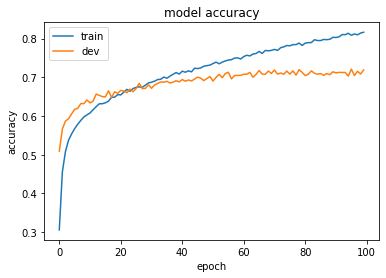

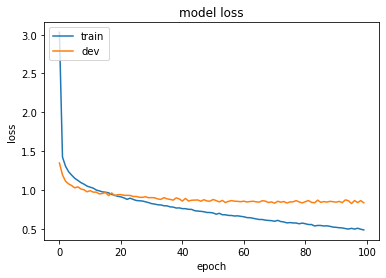

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/cs230 project/models/' + 'RESNET50' + epoch_str + test_acc + '.h5')

# Saving the Model to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='./e-model.h5'
model.save(path)
%cp /content/e-model.h5 /content/drive/My\ Drive

In [ ]:
tf.saved_model.save(model,'./e-model')

In [ ]:
!zip -r E-model.zip {'./e-model'}

  adding: e-model/ (stored 0%)
  adding: e-model/variables/ (stored 0%)
  adding: e-model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: e-model/variables/variables.index (deflated 81%)
  adding: e-model/assets/ (stored 0%)
  adding: e-model/fingerprint.pb (stored 0%)
  adding: e-model/saved_model.pb (deflated 92%)


In [ ]:
%cp /content/E-model.zip /content/drive/My\ Drive

In [ ]:
rel1=keras.models.load_model(
    path
)

In [ ]:
rel1.evaluate(test_gen)

29/29 [==============================] - 11s 337ms/step - loss: 0.8204 - accuracy: 0.7126


[0.8204084634780884, 0.7125731706619263]

# Converting the Model to TFLite and saving it on Drive

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the model.
with open('E_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
%cp /content/E_model.tflite /content/drive/My\ Drive

# Loading the Trained Model

In [ ]:
path='/content/drive/MyDrive/e-model.h5'
model=keras.models.load_model(path)

# Visualizing the Predictions

In [ ]:
image_batch, label_batch = next(iter(train_gen))

#image_batch=image_batch.numpy()
#label_batch=label_batch.numpy()

image_batch=np.array(image_batch)
label_batch=np.array(label_batch)


predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_ids=np.array(predicted_ids)
print((predicted_ids))
predicted_class_names=[]
for i in range(len(predicted_ids)):
  predicted_class_names.append(classes[predicted_ids[i]])

4/4 [==============================] - 9s 45ms/step
[4 3 4 5 3 5 0 3 3 0 4 4 0 6 2 3 2 5 6 5 4 5 5 0 0 1 5 3 3 6 5 4 4 0 3 5 0
 5 4 2 2 5 5 3 2 0 5 4 6 6 5 4 5 2 3 2 6 1 3 3 2 4 3 3 5 3 0 5 6 3 4 0 5 6
 0 5 5 5 3 6 6 3 3 3 5 0 0 4 3 4 0 6 3 2 2 4 4 3 0 0 4 3 6 4 3 3 0 4 4 2 4
 4 6 5 5 0 2 3 0 4 2 0 3 0 0 5 6 3]


In [ ]:
labels=[]
for i in range(len(label_batch)):
  for k in range(len(label_batch[i])):
    if label_batch[i][k]==1.0:
      labels.append(k)
      break
    else:
      continue
print('Labels:  ',labels)
#print('Predicted',predicted_ids)

Labels:   [5, 3, 4, 2, 3, 5, 0, 3, 3, 0, 4, 4, 5, 6, 2, 3, 2, 5, 6, 0, 4, 5, 5, 0, 0, 1, 5, 3, 3, 6, 0, 4, 4, 0, 3, 5, 0, 5, 4, 2, 2, 2, 2, 3, 2, 0, 5, 4, 6, 6, 5, 4, 5, 2, 3, 2, 6, 1, 3, 3, 2, 4, 3, 3, 2, 3, 0, 4, 6, 0, 4, 0, 5, 6, 0, 5, 4, 5, 3, 6, 6, 3, 3, 3, 5, 0, 2, 4, 3, 4, 2, 6, 3, 2, 2, 4, 4, 3, 0, 0, 4, 3, 6, 2, 3, 3, 0, 4, 4, 2, 3, 4, 6, 5, 5, 0, 2, 3, 0, 4, 2, 5, 3, 0, 0, 0, 6, 3]


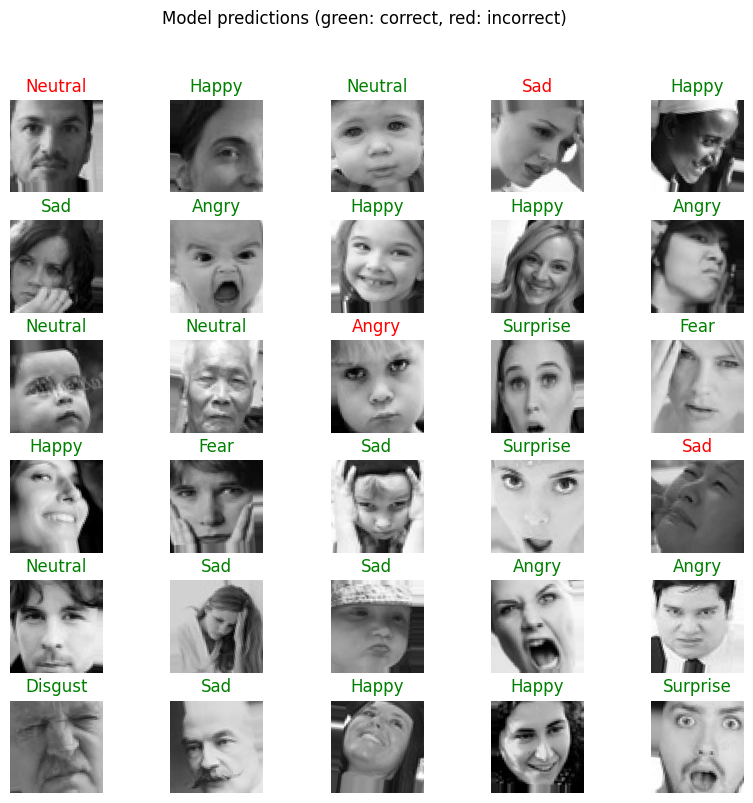

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "green" if (predicted_ids[n] == labels[n]).all() else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Confusion Matrix

In [ ]:
predictions = model.predict(test_gen)

29/29 [==============================] - 9s 300ms/step


In [ ]:
predicted_classes =[]
for pred in predictions:
    predicted_classes.append(np.argmax(pred))

In [ ]:
true_classes = test_gen.classes

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predicted_classes)

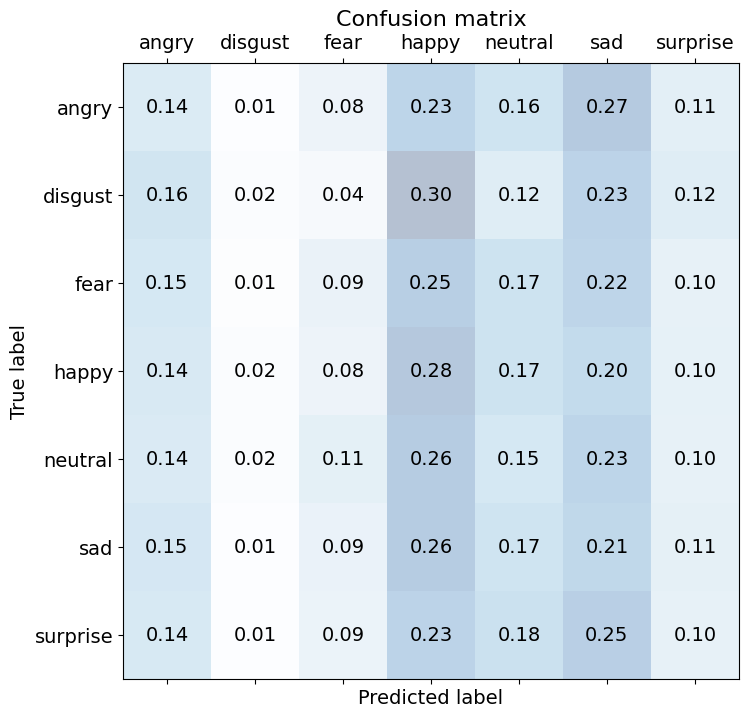

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm_norm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(x=j, y=i, s=format(cm_norm[i, j], '.2f'),
                ha='center', va='center', color='black', fontsize=14)
plt.xticks(np.arange(len(target_names)), target_names, fontsize=14)
plt.yticks(np.arange(len(target_names)), target_names, fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion matrix', fontsize=16)
plt.show()

# Testing the Model on CK+ dataset

In [ ]:
!kaggle datasets download -d shawon10/ckplus

 83% 3.00M/3.63M [00:01<00:00, 3.05MB/s]
100% 3.63M/3.63M [00:01<00:00, 2.75MB/s]


In [ ]:
!unzip ckplus.zip

In [ ]:
test_classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
import os

old_name = r"CK+48/contempt"
new_name = r"CK+48/neutral"
os.rename(old_name, new_name)

In [ ]:
ck_test_dg=ImageDataGenerator(rescale=1./255)
ck_test_gen=test_dg.flow_from_directory('CK+48',
                                   target_size=(IMG_SIZE,IMG_SIZE),
                                   class_mode='categorical',
                                   color_mode='rgb',
                                   shuffle=True,
                                   batch_size=BATCH_SIZE)

Found 981 images belonging to 7 classes.


In [ ]:
print(ck_test_gen.class_indices)
print(val_gen.class_indices)


{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
result = model.evaluate(ck_test_gen)
dict(zip(model.metrics_names, result))

8/8 [==============================] - 2s 265ms/step - loss: 0.9630 - accuracy: 0.6524


{'loss': 0.9629800915718079, 'accuracy': 0.652395486831665}

In [ ]:
import random
y=[random.randint(0,6) for i in range(60)]
print(y)

[4, 1, 3, 0, 5, 0, 0, 3, 4, 1, 1, 6, 3, 5, 3, 3, 5, 3, 6, 3, 4, 6, 5, 5, 5, 5, 6, 4, 1, 3, 0, 1, 1, 4, 3, 6, 2, 4, 0, 4, 0, 2, 2, 5, 3, 1, 0, 6, 2, 2, 3, 5, 0, 4, 2, 1, 5, 2, 2, 5]


ValueError: ignored

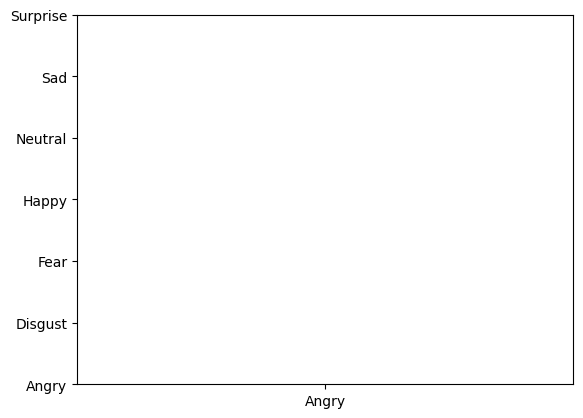

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
x = np.array([classes[random.randint(0,6)] for i in range(60)])
y = range(7)
my_yticks = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
plt.yticks(y, my_yticks)
plt.plot(x, y)
plt.show()

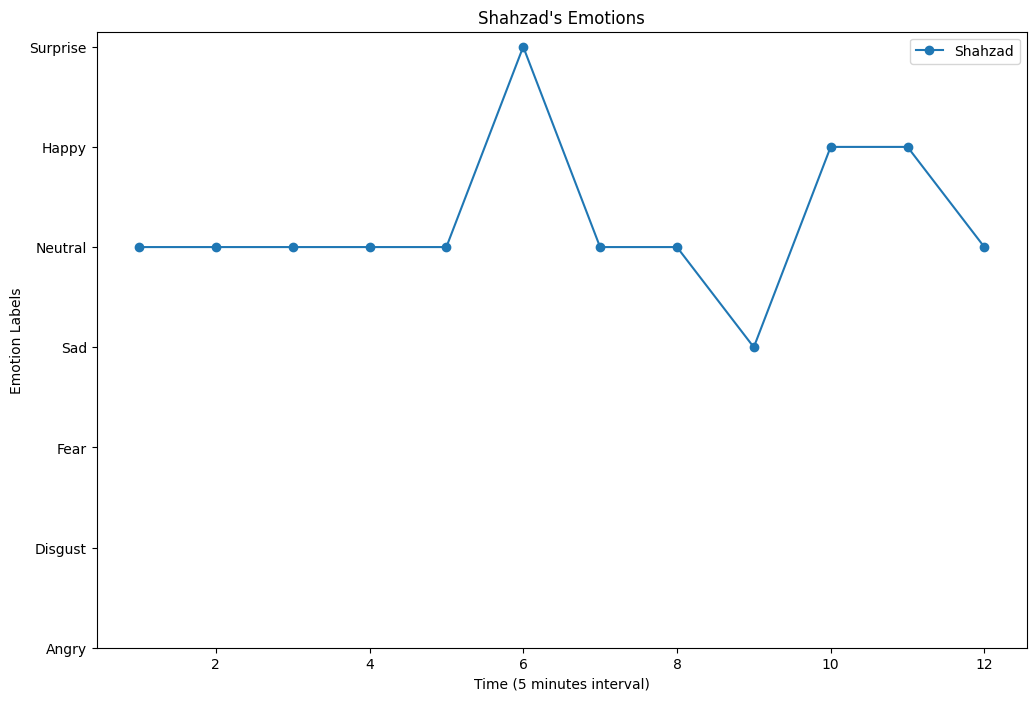

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Sample data (replace with your actual emotion data)
emotions = ['Angry','Disgust','Fear','Sad','Neutral','Happy','Surprise']
time_points = np.arange(1,13)  # Assuming 60 time points
labels=['Shahzad','Pardeep','Muazzam','Qamar']
plt.figure(figsize=(12, 8))
#for i in range(4):
  #emotion_data = np.random.randint(3, 7, 6)
  #emotion_data.extend([7]*30)
  #emotion_data =np.append(emotion_data,[4]*6)
  #np.concatenate(emotion_data,[7]*30)
  #random.shuffle(emotion_data)
shahzad_data=[4,4,4,4,4,6,4,4,3,5,5,4]
qamar_data=[5,5,5,4,4,5,5,4,4,4,5,4]
pardeep_data=[3,5,5,5,4,4,4,5,5,5,6,6]
muazzam_data=[5,4,4,4,6,6,3,3,5,5,4,4]
airaf_data=[3,4,4,4,0,0,3,3,3,0,0,0]

#emotion_data=[4,4,5,4,4,6,4,4,3,5,5,4]
#shahzad_data=[3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3] # Replace with your actual data
#pardeep_data=[3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3]
#muazzam_data=[3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3]
#qamar_data=[3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3]
#airaf_data=[3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,6,6,3,3,3,5,5,5,4,4,4,4,3,3,3,3,3,3]
# Create the line chart
plt.plot(time_points, shahzad_data,marker='o', linestyle='-', label=labels[0])
#plt.plot(time_points, pardeep_data,marker='o', linestyle='-', label=labels[1])
#plt.plot(time_points, muazzam_data,marker='o', linestyle='-', label=labels[2])
#plt.plot(time_points, qamar_data,marker='o', linestyle='-', label=labels[3])
#airaf_data=np.random.randint(0, 3, 6)
#airaf_data =np.append(airaf_data,[4]*6)
#random.shuffle(airaf_data)
#plt.plot(time_points, airaf_data,marker='o', linestyle='-', label='Airaf')


# Customize the chart
plt.legend()
plt.title("Shahzad's Emotions")
plt.xlabel('Time (5 minutes interval)')
plt.ylabel('Emotion Labels')
plt.yticks(range(7), emotions)

# Show the chart
plt.show()
